# 3. PySpark Analysis

In [62]:
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [63]:
import pyspark
import time
import timeit
import pandas as pd

In [64]:
# Create all the file paths here
business_file_path = "../../data/yelp_academic_dataset_business.csv"
users_file_path = "../../data/yelp_academic_dataset_user.csv"
review_file_path = "../../data/review_sampled_1M.csv"

In [65]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("Load_tables").getOrCreate()

# Load a CSV file into a DataFrame
business_df = spark.read.csv(business_file_path, header=True, inferSchema=True)
users_df = spark.read.csv(users_file_path, header=True, inferSchema=True)
review_sampled_df = spark.read.csv(review_file_path, header=True, inferSchema=True)

# Show the first 5 rows of the DataFrame
business_df.show(5)
# Perform a simple transformation: filter records where 'age' > 30


+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|         city|state|postal_code|  latitude|   longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|1616 Chapala St, ...|Santa Barbara|   CA|      93101|34.4266787|-119.7111968|  5.0|         7.0|      0|{'ByAppointmentOn...|Doctors, Traditio...|                NULL|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|87 Grasso Plaza S...|       Affton|   MO|      63123| 38.551126|  -90.335695|  3.0|        15.0|      1|{'Busines

In [66]:
review_sampled_df.show(5)

+--------------------+--------------------+--------------------+-------------------+------+-----+----+--------------------+-------------------+
|           review_id|             user_id|         business_id|              stars|useful|funny|cool|                text|               date|
+--------------------+--------------------+--------------------+-------------------+------+-----+----+--------------------+-------------------+
|S8jdwyhSsz30eNegD...|86WYiv6T14Fbf2x0y...|B91yBSPvAz5O_t9JF...|                  5|     0|    0|   0|I absolutely love...|               NULL|
|People that I Kno...| 2016-05-31 04:46:41|                NULL|               NULL|  NULL| NULL|NULL|                NULL|               NULL|
|nAx6LHi2qcvh1Rg9M...|s_tmMM7ZV6LyRosVL...|jxfAi7UDmtbhyPw7Z...|                  3|     0|    0|   0|The food is reall...|               NULL|
|Will probably go ...| I applied the co...| her tip dropped ...|2018-08-04 20:20:55|  NULL| NULL|NULL|                NULL|             

In [67]:
users_df.show(5)

+--------------------+------+------------+-------------------+------+-----+-----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|             user_id|  name|review_count|      yelping_since|useful|funny| cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|
+--------------------+------+------------+-------------------+------+-----+-----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|qVc8ODYU5SZjKXVBg.

*Location:

Find the city with the closest highest number of highest rated business 
What’s the best area or region 
GROUP BY reviews per city
SUM count business
AVG rating
Join between reviews, and busineses
ex) find the highest concentration of bars in different regions


## Preprocessing Execution Times

In [68]:
import matplotlib.pyplot as plt

def plot_graph_with_times(execution_times):
    """
    Arg: 
    execution_times = a dictionary with keys as sample_size and values as execution time
    --> This is generated from running the query on various sample sizes
    """

    # Plot a graph with the dictionary of sample_size to execution_time
    plt.figure(figsize=(10, 6))
    plt.plot(list(execution_times.keys()), list(execution_times.values()), marker="o")
    plt.xscale("log")
    plt.xlabel("Sample Size")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Execution Time vs. Sample Size")
    plt.grid(True)
    plt.show()

In [69]:
# define a function that takes in the query number and execution times, and dumps it into a json
def execution_times_to_json(query_number, execution_times):
    """
    Arg: 
    query_number = a string with the query number
    execution_times = a dictionary with keys as sample_size and values as execution time
    --> This is generated from running the query on various sample sizes
    """
    # Dump the execution times into a json file
    with open(f"{query_number}_execution_times_pyspark.json", "w") as f:
        json.dump(execution_times, f)

# Query 1: Top 10 Cities

In [70]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, sum

# Initialize Spark session
spark = SparkSession.builder.appName("CTE to Spark").getOrCreate()

24/12/11 15:42:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


EQUIVALENT TO CTE ranked_business




```
WITH ranked_business AS (
    
        SELECT 
            yb.business_id,
            yb.city,
            yb.review_count,
            yb.stars,
            CASE WHEN yb.stars > 4.7 AND yb.review_count > 100
            THEN 1
            ELSE 0
            END AS is_good
        FROM yelp_business yb
    )



In [71]:
ranked_business = business_df.withColumn(
    "is_good",
    when((col("stars") > 4.7) & (col("review_count") > 100), 1).otherwise(0)
).select("business_id", "city", "review_count", "stars", "is_good")
ranked_business.explain()

== Physical Plan ==
*(1) Project [business_id#13502, city#13505, review_count#13511, stars#13510, CASE WHEN ((stars#13510 > 4.7) AND (review_count#13511 > 100.0)) THEN 1 ELSE 0 END AS is_good#13857]
+- FileScan csv [business_id#13502,city#13505,stars#13510,review_count#13511] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<business_id:string,city:string,stars:double,review_count:double>




EQUIVALENT TO CTE concentration_by_city 
```
concentration_by_city AS (
    
        SELECT 
            city,
            COUNT(business_id) as num_business,
            SUM(is_good) as total_is_good
        FROM ranked_business
        GROUP BY city
        HAVING COUNT(business_id) > 50
        ORDER BY total_is_good DESC
    )




In [72]:
concentration_by_city = (
    ranked_business.groupBy("city")
    .agg(
        count("business_id").alias("num_business"),
        sum("is_good").alias("total_is_good")
    )
    .filter(col("num_business") > 50) 
    .orderBy(col("total_is_good").desc()) 
)
concentration_by_city.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [total_is_good#13886L DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(total_is_good#13886L DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=21252]
      +- Filter (num_business#13884L > 50)
         +- HashAggregate(keys=[city#13505], functions=[count(business_id#13502), sum(is_good#13857)])
            +- Exchange hashpartitioning(city#13505, 200), ENSURE_REQUIREMENTS, [plan_id=21248]
               +- HashAggregate(keys=[city#13505], functions=[partial_count(business_id#13502), partial_sum(is_good#13857)])
                  +- Project [business_id#13502, city#13505, CASE WHEN ((stars#13510 > 4.7) AND (review_count#13511 > 100.0)) THEN 1 ELSE 0 END AS is_good#13857]
                     +- FileScan csv [business_id#13502,city#13505,stars#13510,review_count#13511] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-

EQUIVALENT TO SELECT * FROM concentration_by_city LIMIT 10;
**

In [73]:
result = concentration_by_city.limit(10)
result.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- TakeOrderedAndProject(limit=10, orderBy=[total_is_good#13886L DESC NULLS LAST], output=[city#13505,num_business#13884L,total_is_good#13886L])
   +- Filter (num_business#13884L > 50)
      +- HashAggregate(keys=[city#13505], functions=[count(business_id#13502), sum(is_good#13857)])
         +- Exchange hashpartitioning(city#13505, 200), ENSURE_REQUIREMENTS, [plan_id=21274]
            +- HashAggregate(keys=[city#13505], functions=[partial_count(business_id#13502), partial_sum(is_good#13857)])
               +- Project [business_id#13502, city#13505, CASE WHEN ((stars#13510 > 4.7) AND (review_count#13511 > 100.0)) THEN 1 ELSE 0 END AS is_good#13857]
                  +- FileScan csv [business_id#13502,city#13505,stars#13510,review_count#13511] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFil

In [74]:
# Show the result
result.show()

+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|       14569|           43|
|           Tampa|        9050|           32|
|   Santa Barbara|        3829|           30|
|     New Orleans|        6208|           26|
|            Reno|        5935|           21|
|    Indianapolis|        7540|           19|
|       Nashville|        6971|           18|
|          Tucson|        9250|            9|
|     Saint Louis|        4827|            6|
|Saint Petersburg|        1663|            6|
+----------------+------------+-------------+



In [75]:
def query_1(business_df):
    # Add a new column "is_good" based on the conditions
    ranked_business = business_df.withColumn(
        "is_good",
        when((col("stars") > 4.7) & (col("review_count") > 100), 1).otherwise(0)
    )

    # Select necessary columns
    ranked_business = ranked_business.select("business_id", "city", "review_count", "stars", "is_good")
    
    # Group by city and aggregate data
    concentration_by_city = (
        ranked_business.groupBy("city")
        .agg(
            count("business_id").alias("num_business"),
            sum("is_good").alias("total_is_good")
        )
        .filter(col("num_business") > 50)  # Filter cities with more than 50 businesses
        .orderBy(col("total_is_good").desc())  # Sort by total "is_good" businesses in descending order
    )

    # Get the top 10 cities
    result = concentration_by_city.limit(10)
    
    # Display the results
    result.show()
    

Run the analysis on the execution times depending on scale of input and size.

Running the query for sample size: 100
+----+------------+-------------+
|city|num_business|total_is_good|
+----+------------+-------------+
+----+------------+-------------+

Execution time: 0.18 seconds
+----+------------+-------------+
|city|num_business|total_is_good|
+----+------------+-------------+
+----+------------+-------------+

Execution time: 0.14 seconds
+----+------------+-------------+
|city|num_business|total_is_good|
+----+------------+-------------+
+----+------------+-------------+

Execution time: 0.15 seconds
+----+------------+-------------+
|city|num_business|total_is_good|
+----+------------+-------------+
+----+------------+-------------+

Execution time: 0.15 seconds
+----+------------+-------------+
|city|num_business|total_is_good|
+----+------------+-------------+
+----+------------+-------------+

Execution time: 0.18 seconds
+----+------------+-------------+
|city|num_business|total_is_good|
+----+------------+-------------+
+----+------------+----------

+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|     New Orleans|        4137|           14|
|       Nashville|        4606|           13|
|    Indianapolis|        5003|           10|
|          Tucson|        6166|            7|
|     Saint Louis|        3268|            5|
|Saint Petersburg|        1094|            4|
+----------------+------------+-------------+

Execution time: 1.07 seconds
+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|   

+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|     New Orleans|        4137|           14|
|       Nashville|        4606|           13|
|    Indianapolis|        5003|           10|
|          Tucson|        6166|            7|
|     Saint Louis|        3268|            5|
|Saint Petersburg|        1094|            4|
+----------------+------------+-------------+

Execution time: 0.71 seconds
+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|   

+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|     New Orleans|        4137|           14|
|       Nashville|        4606|           13|
|    Indianapolis|        5003|           10|
|          Tucson|        6166|            7|
|     Saint Louis|        3268|            5|
|Saint Petersburg|        1094|            4|
+----------------+------------+-------------+

Execution time: 1.04 seconds
+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|   

+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|     New Orleans|        4137|           14|
|       Nashville|        4606|           13|
|    Indianapolis|        5003|           10|
|          Tucson|        6166|            7|
|     Saint Louis|        3268|            5|
|Saint Petersburg|        1094|            4|
+----------------+------------+-------------+

Execution time: 0.95 seconds


+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|     New Orleans|        4137|           14|
|       Nashville|        4606|           13|
|    Indianapolis|        5003|           10|
|          Tucson|        6166|            7|
|     Saint Louis|        3268|            5|
|Saint Petersburg|        1094|            4|
+----------------+------------+-------------+

Execution time: 0.70 seconds
+----------------+------------+-------------+
|            city|num_business|total_is_good|
+----------------+------------+-------------+
|    Philadelphia|        9670|           30|
|           Tampa|        6030|           20|
|   Santa Barbara|        2539|           20|
|            Reno|        3968|           14|
|   

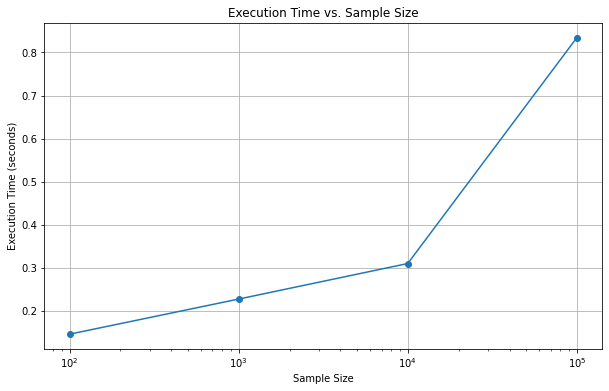

In [76]:
import numpy as np

# List of the sample sizes
sample_sizes = [10 ** i for i in range(2, 6)]

# Dictionary to hold the execution times
execution_times = {}

for sample_size in sample_sizes:
    print(f"Running the query for sample size: {sample_size}")
    business_sample_path = f"../../data/business_sample_{sample_size}.csv"
    business_sample_df = spark.read.csv(business_sample_path, header=True, inferSchema=True)
    
    times = []
    for i in range(10):
        start_time = time.time()
        query_1(business_sample_df)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time:.2f} seconds")
        times.append(execution_time)
    
    # Take the average execution time
    average_execution_time = np.average(times)
    
    # Save the sample size and corresponding execution time into a dictionary
    execution_times[sample_size] = average_execution_time

# Print the execution times
print(execution_times)

# Plot the graph with execution times
plot_graph_with_times(execution_times)

# Query 2: The Top Business in Every Yelp Category

CREATE CTE parsed_categories

```
   WITH parsed_categories AS (
    SELECT
        yb.business_id,
        yb.city,
        yb.state,
        yb.name,
        yb.stars,
        yb.review_count,
        UNNEST(yb.categories) AS category
    FROM yelp_business yb
    )


In [77]:
from pyspark.sql.functions import explode, split

# Assuming `yelp_business_df` is your PySpark DataFrame
# Load a CSV file into a DataFrame
business_df = spark.read.csv(business_file_path, header=True, inferSchema=True)

# Transform `categories` string into an array
parsed_categories_df = (
    business_df
    .withColumn("categories_array", split("categories", ", "))  # Split string into an array
    .withColumn("category", explode("categories_array"))       # Explode the array into rows
    .select(
        "business_id",
        "city",
        "state",
        "name",
        "stars",
        "review_count",
        "category"
    )
)

# Show the resulting DataFrame
parsed_categories_df.explain()
parsed_categories_df.show()


== Physical Plan ==
*(1) Project [business_id#16436, city#16439, state#16440, name#16437, stars#16444, review_count#16445, category#16482]
+- *(1) Generate explode(categories_array#16464), [business_id#16436, name#16437, city#16439, state#16440, stars#16444, review_count#16445], false, [category#16482]
   +- *(1) Project [business_id#16436, name#16437, city#16439, state#16440, stars#16444, review_count#16445, split(categories#16448, , , -1) AS categories_array#16464]
      +- *(1) Filter ((size(split(categories#16448, , , -1), true) > 0) AND isnotnull(split(categories#16448, , , -1)))
         +- FileScan csv [business_id#16436,name#16437,city#16439,state#16440,stars#16444,review_count#16445,categories#16448] Batched: false, DataFilters: [(size(split(categories#16448, , , -1), true) > 0), isnotnull(split(categories#16448, , , -1))], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFi

CREATE CTE parsed_categories
```
num_categories AS (
        SELECT DISTINCT
            category,
            COUNT(*) AS num_category
        FROM parsed_categories
        GROUP BY category
    )

In [78]:
from pyspark.sql.functions import explode, split

# Transform `categories` string into an array
from pyspark.sql.functions import count

# Group by 'category' and count occurrences
num_categories_df = (
    parsed_categories_df
    .groupBy("category")               
    .agg(count("*").alias("num_category")) 
)

# Show the result
num_categories_df.explain()
num_categories_df.show()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[category#16482], functions=[count(1)])
   +- Exchange hashpartitioning(category#16482, 200), ENSURE_REQUIREMENTS, [plan_id=24021]
      +- HashAggregate(keys=[category#16482], functions=[partial_count(1)])
         +- Generate explode(categories_array#16464), false, [category#16482]
            +- Project [split(categories#16448, , , -1) AS categories_array#16464]
               +- Filter ((size(split(categories#16448, , , -1), true) > 0) AND isnotnull(split(categories#16448, , , -1)))
                  +- FileScan csv [categories#16448] Batched: false, DataFilters: [(size(split(categories#16448, , , -1), true) > 0), isnotnull(split(categories#16448, , , -1))], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<categories:string>




+--------------------+------------+
|            category|num_category|
+--------------------+------------+
|     'HasTV': 'True'|        1096|
|      Dermatologists|         200|
|    Historical Tours|          96|
| 'BYOBCorkage': "...|          38|
| 'DogsAllowed': '...|         136|
|     Pet Photography|          17|
|       Data Recovery|          65|
|        Aerial Tours|           9|
|         Boat Repair|          53|
|             Beaches|          16|
|       Videographers|          55|
|   Pet Waste Removal|           9|
|         Hobby Shops|          66|
|               Reiki|          46|
| 'BusinessParking...|         145|
|            Day Spas|         156|
|            Honduran|           4|
|          Gymnastics|          13|
|          Bubble Tea|          41|
|         Shoe Repair|         161|
+--------------------+------------+
only showing top 20 rows



CREATE CTE ranked_businesses
```
ranked_businesses AS (
        SELECT
            pc.category,
            pc.business_id,
            pc.name,
            pc.city,
            pc.state,
            pc.stars,
            pc.review_count,
            nc.num_category,
            RANK() OVER (
                PARTITION BY pc.category
                ORDER BY pc.stars DESC, pc.review_count DESC
            ) AS rank_in_category
        FROM parsed_categories pc
        JOIN num_categories nc ON pc.category = nc.category
    )

In [79]:
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

# Join parsed_categories_df with num_categories_df
joined_df = (
    parsed_categories_df
    .join(num_categories_df, "category", "inner")  # Join on the 'category' column
)
joined_df.explain()

window_spec = Window.partitionBy("category").orderBy(col("stars").desc(), col("review_count").desc())

ranked_businesses_df = (
    joined_df
    .withColumn("rank_in_category", rank().over(window_spec))  # Add ranking based on the window spec
    .select(
        "category",
        "business_id",
        "name",
        "city",
        "state",
        "stars",
        "review_count",
        "num_category",
        "rank_in_category"
    )
)
ranked_businesses_df.explain()

# Show the result
ranked_businesses_df.show()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [category#16482, business_id#16436, city#16439, state#16440, name#16437, stars#16444, review_count#16445, num_category#16550L]
   +- SortMergeJoin [category#16482], [category#16579], Inner
      :- Sort [category#16482 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(category#16482, 200), ENSURE_REQUIREMENTS, [plan_id=24138]
      :     +- Project [business_id#16436, city#16439, state#16440, name#16437, stars#16444, review_count#16445, category#16482]
      :        +- Generate explode(categories_array#16464), [business_id#16436, name#16437, city#16439, state#16440, stars#16444, review_count#16445], false, [category#16482]
      :           +- Project [business_id#16436, name#16437, city#16439, state#16440, stars#16444, review_count#16445, split(categories#16448, , , -1) AS categories_array#16464]
      :              +- Filter ((size(split(categories#16448, , , -1), true) > 0) AND isnotnull(split(catego

+--------------------+--------------------+--------------------+-------------+-----+-----+------------+------------+----------------+
|            category|         business_id|                name|         city|state|stars|review_count|num_category|rank_in_category|
+--------------------+--------------------+--------------------+-------------+-----+-----+------------+------------+----------------+
| 'AcceptsInsuranc...|8IIgDEmSZwJ8kNcrc...|Traders Point Dental| Indianapolis|   IN|  5.0|        60.0|         198|               1|
| 'AcceptsInsuranc...|J8BZnWArQMiHPnDZr...|    Erik S Wipf, DDS|Santa Barbara|   CA|  5.0|        56.0|         198|               2|
| 'AcceptsInsuranc...|MX9gdPpixg0drDv8r...|    Corner Dentistry| Philadelphia|   PA|  5.0|        41.0|         198|               3|
| 'AcceptsInsuranc...|lvV8nlpLcTADBni2t...|Dentistry in Para...|Santa Barbara|   CA|  5.0|        39.0|         198|               4|
| 'AcceptsInsuranc...|akBEZSCE6gfhAk7fO...|Cool Springs Chir..

 ```
 SELECT
        category,
        num_category,
        business_id,
        name,
        city,
        state,
        stars,
        review_count
    FROM ranked_businesses
    WHERE rank_in_category = 1
    ORDER BY num_category DESC;

In [80]:
# Filter for rank_in_category = 1 and order by num_category descending
final_ranked_df = (
    ranked_businesses_df
    .filter(col("rank_in_category") == 1)  # Filter for rank = 1
    .orderBy(col("num_category").desc())  # Order by num_category in descending order
    .select(
        "category",
        "num_category",
        "business_id",
        "name",
        "city",
        "state",
        "stars",
        "review_count"
    )
)
final_ranked_df.explain()
# Show the result
final_ranked_df.show(5)


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [category#16482, num_category#16550L, business_id#16436, name#16437, city#16439, state#16440, stars#16444, review_count#16445]
   +- Sort [num_category#16550L DESC NULLS LAST], true, 0
      +- Exchange rangepartitioning(num_category#16550L DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=24561]
         +- Project [category#16482, business_id#16436, name#16437, city#16439, state#16440, stars#16444, review_count#16445, num_category#16550L]
            +- Filter (rank_in_category#16591 = 1)
               +- Window [rank(stars#16444, review_count#16445) windowspecdefinition(category#16482, stars#16444 DESC NULLS LAST, review_count#16445 DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS rank_in_category#16591], [category#16482], [stars#16444 DESC NULLS LAST, review_count#16445 DESC NULLS LAST]
                  +- WindowGroupLimit [category#16482], [stars#16444 DESC NULLS LAST, 

+----------------+------------+--------------------+--------------------+--------------+-----+-----+------------+
|        category|num_category|         business_id|                name|          city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+--------------+-----+-----+------------+
| 'street': False|       34898|P2lgVD6rQVmOaPlYB...|  Break Through Reno|          Reno|   NV|  5.0|       335.0|
|   Home Services|       12491|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|  Philadelphia|   PA|  5.0|       398.0|
|  'street': True|       10483|l_7TW_Ix58-QvhQgp...|   SUGARED + BRONZED|  Philadelphia|   PA|  5.0|       513.0|
|      Automotive|        8816|eJUjeWndPCCqTjj0J...|Sterling Carpet Care|          Reno|   NV|  5.0|       276.0|
|Health & Medical|        7395|2bVR-HHvTHteXpoek...|Norman Parathyroi...|Town N Country|   FL|  5.0|       124.0|
+----------------+------------+--------------------+--------------------+--------------+

In [81]:
# Create query 2
def query_2(business_df):
    # Assuming `yelp_business_df` is your PySpark DataFrame
    # Load a CSV file into a DataFrame

    # Transform `categories` string into an array
    parsed_categories_df = (
        business_df
        .withColumn("categories_array", split("categories", ", "))  # Split string into an array
        .withColumn("category", explode("categories_array"))       # Explode the array into rows
        .select(
            "business_id",
            "city",
            "state",
            "name",
            "stars",
            "review_count",
            "category"
        )
    )

    # Group by 'category' and count occurrences
    # Group by 'category' and count occurrences
    num_categories_df = (
        parsed_categories_df
        .groupBy("category")               
        .agg(count("*").alias("num_category")) 
    )

    joined_df = (
        parsed_categories_df
        .join(num_categories_df, "category", "inner")  # Join on the 'category' column
    )

    joined_df.explain()

    window_spec = Window.partitionBy("category").orderBy(col("stars").desc(), col("review_count").desc())

    ranked_businesses_df = (
        joined_df
        .withColumn("rank_in_category", rank().over(window_spec))  # Add ranking based on the window spec
        .select(
            "category",
            "business_id",
            "name",
            "city",
            "state",
            "stars",
            "review_count",
            "num_category",
            "rank_in_category"
        )
    )

    final_ranked_df = (
    ranked_businesses_df
    .filter(col("rank_in_category") == 1)  # Filter for rank = 1
    .orderBy(col("num_category").desc())  # Order by num_category in descending order
    .select(
        "category",
        "num_category",
        "business_id",
        "name",
        "city",
        "state",
        "stars",
        "review_count"
    )
    )   
    
    final_ranked_df.show(5)

In [82]:
business_df = spark.read.csv(business_file_path, header=True, inferSchema=True)
query_2(business_df)

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [category#16775, business_id#16729, city#16732, state#16733, name#16730, stars#16737, review_count#16738, num_category#16807L]
   +- SortMergeJoin [category#16775], [category#16824], Inner
      :- Sort [category#16775 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(category#16775, 200), ENSURE_REQUIREMENTS, [plan_id=24967]
      :     +- Project [business_id#16729, city#16732, state#16733, name#16730, stars#16737, review_count#16738, category#16775]
      :        +- Generate explode(categories_array#16757), [business_id#16729, name#16730, city#16732, state#16733, stars#16737, review_count#16738], false, [category#16775]
      :           +- Project [business_id#16729, name#16730, city#16732, state#16733, stars#16737, review_count#16738, split(categories#16741, , , -1) AS categories_array#16757]
      :              +- Filter ((size(split(categories#16741, , , -1), true) > 0) AND isnotnull(split(catego

+----------------+------------+--------------------+--------------------+--------------+-----+-----+------------+
|        category|num_category|         business_id|                name|          city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+--------------+-----+-----+------------+
| 'street': False|       34898|P2lgVD6rQVmOaPlYB...|  Break Through Reno|          Reno|   NV|  5.0|       335.0|
|   Home Services|       12491|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|  Philadelphia|   PA|  5.0|       398.0|
|  'street': True|       10483|l_7TW_Ix58-QvhQgp...|   SUGARED + BRONZED|  Philadelphia|   PA|  5.0|       513.0|
|      Automotive|        8816|eJUjeWndPCCqTjj0J...|Sterling Carpet Care|          Reno|   NV|  5.0|       276.0|
|Health & Medical|        7395|2bVR-HHvTHteXpoek...|Norman Parathyroi...|Town N Country|   FL|  5.0|       124.0|
+----------------+------------+--------------------+--------------------+--------------+

Running the query for sample size: 100
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [category#16977, business_id#16931, city#16934, state#16935, name#16932, stars#16939, review_count#16940, num_category#17009L]
   +- BroadcastHashJoin [category#16977], [category#17026], Inner, BuildRight, false
      :- Project [business_id#16931, city#16934, state#16935, name#16932, stars#16939, review_count#16940, category#16977]
      :  +- Generate explode(categories_array#16959), [business_id#16931, name#16932, city#16934, state#16935, stars#16939, review_count#16940], false, [category#16977]
      :     +- Project [business_id#16931, name#16932, city#16934, state#16935, stars#16939, review_count#16940, split(categories#16943, , , -1) AS categories_array#16959]
      :        +- Filter ((size(split(categories#16943, , , -1), true) > 0) AND isnotnull(split(categories#16943, , , -1)))
      :           +- FileScan csv [business_id#16931,name#16932,city#16934,state#16935,stars#1

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
|        category|num_category|         business_id|                name|        city|state|stars|review_count|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------------+
| 'street': False|       23254|P2lgVD6rQVmOaPlYB...|  Break Through Reno|        Reno|   NV|  5.0|       335.0|
|   Home Services|        8390|u3zqvp4BYUjzJD7tz...|JB Plumbing and H...|Philadelphia|   PA|  5.0|       398.0|
|  'street': True|        6974|xBPg6gzunjpEUT6Fi...|       Big Al's Deli|   Nashville|   TN|  5.0|       390.0|
|      Automotive|        5839|jMzcn59A2OYZ3zv2B...|Fernando's Smog C...|      Goleta|   CA|  5.0|       193.0|
|  Local Services|        4887|o_N7HiU3f6cVvrJAF...|KC Carpet and Uph...|Philadelphia|   PA|  5.0|       252.0|
+----------------+------------+--------------------+--------------------+------------+-----+-----+------

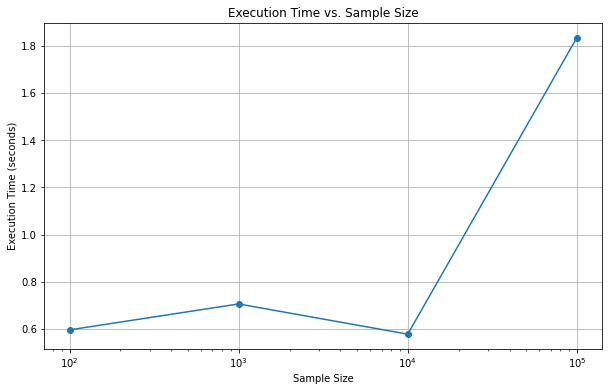

In [83]:
# Run the query execution time processing and calculations here

# List of the sample sizes
sample_sizes = [10 ** i for i in range(2, 6)]

# Dictionary to hold the execution times
execution_times = {}

for sample_size in sample_sizes:
    print(f"Running the query for sample size: {sample_size}")
    business_sample_path = f"../../data/business_sample_{sample_size}.csv"
    business_sample_df = spark.read.csv(business_sample_path, header=True, inferSchema=True)
    
    times = []
    for i in range(10):
        start_time = time.time()
        query_2(business_sample_df)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time:.2f} seconds")
        times.append(execution_time)
    
    # Take the average execution time
    average_execution_time = np.average(times)
    
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")

    # Save the sample size and corresponding execution time into a dictionary
    execution_times[sample_size] = execution_time

# Print the execution times
print(execution_times)

# Plot the graph with execution times
plot_graph_with_times(execution_times)

# Query 3: Most Popular Month for Restaurant Reviews


```
SELECT
       TO_CHAR(ysr.date, 'Month') AS review_month,
       AVG(yb.stars) AS avg_stars,
       AVG(yb.review_count) AS avg_review_count,
       COUNT(ysr.review_id) AS total_reviews
   FROM yelp_business yb
   JOIN yelp_small_reviews ysr ON yb.business_id = ysr.business_id
   WHERE 'Restaurants' = ANY(yb.categories)
   GROUP BY review_month
   ORDER BY avg_review_count DESC LIMIT 1


In [84]:
from pyspark.sql import functions as F

def query_3_pyspark(business_df, reviews_df):
    # Filter the businesses to only those with the 'Restaurants' category
    restaurants_df = business_df.filter(
        F.array_contains(F.col("categories"), "Restaurants")
    )
    
    # Join the filtered businesses with the reviews dataframe
    joined_df = restaurants_df.join(
        reviews_df, on="business_id", how="inner"
    )
    
    # Extract the month from the review date
    joined_df = joined_df.withColumn(
        "review_month", F.date_format(F.col("date"), "MMMM")
    )
    
    # Aggregate data by review_month
    aggregated_df = joined_df.groupBy("review_month").agg(
        F.avg("stars").alias("avg_stars"),
        F.avg("review_count").alias("avg_review_count"),
        F.count("review_id").alias("total_reviews")
    )
    
    # Order by average review count in descending order
    result_df = aggregated_df.orderBy(F.col("avg_review_count").desc())
    result_df.show()
    result_df.explain()


In [85]:
query_3_pyspark(business_df, review_sampled_df)

AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "array_contains(categories, Restaurants)" due to data type mismatch: Parameter 1 requires the "ARRAY" type, however "categories" has the type "STRING".;
'Filter array_contains(categories#16741, Restaurants)
+- Relation [business_id#16729,name#16730,address#16731,city#16732,state#16733,postal_code#16734,latitude#16735,longitude#16736,stars#16737,review_count#16738,is_open#16739,attributes#16740,categories#16741,hours#16742] csv


# Query 4: Which User Has Most Friends

```
    SELECT 
        user_id, 
        name, 
        array_length(STRING_TO_ARRAY(friends, ','), 1) as number_of_friends
    FROM yelp_users
    ORDER BY number_of_friends DESC;


In [ ]:
from pyspark.sql.functions import  col, split, size


most_friends = users_df.withColumn(
    "number_of_friends", size(split(col("friends"), ","))).select("user_id", "name", "number_of_friends")  
most_friends.explain()

== Physical Plan ==
*(1) Project [user_id#62, name#63, size(split(friends#70, ,, -1), true) AS number_of_friends#4159]
+- FileScan csv [user_id#62,name#63,friends#70] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,friends:string>




In [ ]:
def query_4(users_df):
    most_friends = users_df.withColumn("number_of_friends", size(split(col("friends"), ","))).select("user_id", "name", "number_of_friends").orderBy(col("number_of_friends").desc()) 
    most_friends.show()
    most_friends.explain()

In [ ]:
query_4(users_df)

ConnectionRefusedError: [Errno 61] Connection refused

Running the query for sample size: 100
+--------------------+--------+-----------------+
|             user_id|    name|number_of_friends|
+--------------------+--------+-----------------+
|2M01rniHjqap5IBVQ...|     Amy|              113|
|6-YEfYffIq30kyCWQ...|     Joe|               23|
|fdRGp5Mp2Cbl5JTei...|   David|              404|
|GmQR50bIII7gDNRYE...| Tiffany|             1286|
|O7ly1kO-eDJv9uGuy...|  Andrew|              294|
|SNMkSpTy6buAfhKx6...|     Ted|              832|
|qwvxMDOxj0k2sfydw...| theresa|               47|
|k_muz40jJaiY1PVga...|   Louis|              398|
|LNz5NSoV8XVZhxIp5...|     Jay|              345|
|ITa3vh5ERI90G_WP4...|   Peter|             6417|
|QldTZz8E1mTzFBmmc...|  Yoshie|              122|
|zx2NykkcJd1vdOgoS...|   Marek|               40|
|IxOblhSSL_9vEUf3a...|   David|                4|
|w-w-k-QXosIKQ8HQV...| Anthony|             6109|
|j1JLPKieLDpFznz1A...|    Katy|               71|
|EnZb0blM78cUkBLfe...| Caitlin|              225|
|lHK2jZ1sAG

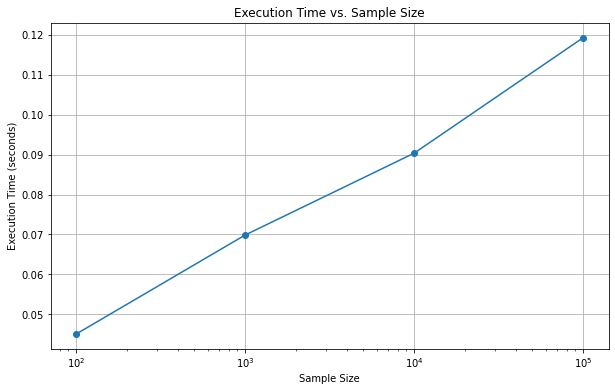

In [ ]:
# Run the query execution time processing and calculations here
# List of the sample sizes
sample_sizes = [10 ** i for i in range(2, 6)]

# Dictionary to hold the execution times
execution_times = {}

for sample_size in sample_sizes:
    print(f"Running the query for sample size: {sample_size}")
    users_sample_path = f"../../data/users_sample_{sample_size}.csv"
    users_sample_df = spark.read.csv(users_sample_path, header=True, inferSchema=True)
    
    times = []
    for i in range(10):
        start_time = time.time()
        query_4(users_sample_df)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time:.2f} seconds")
        times.append(execution_time)
    
    # Take the average execution time
    average_execution_time = np.average(times)
    
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")

    # Save the sample size and corresponding execution time into a dictionary
    execution_times[sample_size] = execution_time

# Print the execution times
print(execution_times)

# Plot the graph with execution times
plot_graph_with_times(execution_times)

In [88]:
from pyspark.sql.functions import  col, split, size

most_friends = users_df.withColumn(
    "number_of_friends", size(split(col("friends"), ","))).select("user_id", "name", "number_of_friends")  
most_friends.explain()

== Physical Plan ==
*(1) Project [user_id#13547, name#13548, size(split(friends#13555, ,, -1), true) AS number_of_friends#24453]
+- FileScan csv [user_id#13547,name#13548,friends#13555] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,friends:string>




# Query 5: Food Adventurer

We want to identify users that have reviewed businesses in more than 5 cities. 


In [89]:
# Import F
from pyspark.sql.functions import col, split, size
from pyspark.sql import functions as F  # Import functions as F

In [90]:
# Load a CSV file into a DataFrame
from pyspark.sql.functions import col, desc
business_df = spark.read.csv(business_file_path, header=True, inferSchema=True)
business_df = business_df.select(
        *[F.col(c).alias(f"businesses_{c}") for c in business_df.columns])

In [91]:
user_business = (
    review_sampled_df
    .join(
        business_df,
        review_sampled_df.business_id == business_df.businesses_business_id,
        "inner"
    )) 
user_business.explain()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [business_id#13610], [businesses_business_id#24525], Inner
   :- Sort [business_id#13610 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(business_id#13610, 200), ENSURE_REQUIREMENTS, [plan_id=41542]
   :     +- Filter isnotnull(business_id#13610)
   :        +- FileScan csv [review_id#13608,user_id#13609,business_id#13610,stars#13611,useful#13612,funny#13613,cool#13614,text#13615,date#13616] Batched: false, DataFilters: [isnotnull(business_id#13610)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [IsNotNull(business_id)], ReadSchema: struct<review_id:string,user_id:string,business_id:string,stars:string,useful:string,funny:string...
   +- Sort [businesses_business_id#24525 ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(businesses_business_id#24525, 200), ENSURE_REQUIREMEN

In [92]:
from pyspark.sql.functions import concat, lit
user_business = user_business.withColumn(
    "city_state",
    concat(user_business.businesses_city, lit(", "), user_business.businesses_state)
)
user_business.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [review_id#13608, user_id#13609, business_id#13610, stars#13611, useful#13612, funny#13613, cool#13614, text#13615, date#13616, businesses_business_id#24525, businesses_name#24526, businesses_address#24527, businesses_city#24528, businesses_state#24529, businesses_postal_code#24530, businesses_latitude#24531, businesses_longitude#24532, businesses_stars#24533, businesses_review_count#24534, businesses_is_open#24535, businesses_attributes#24536, businesses_categories#24537, businesses_hours#24538, concat(businesses_city#24528, , , businesses_state#24529) AS city_state#24600]
   +- SortMergeJoin [business_id#13610], [businesses_business_id#24525], Inner
      :- Sort [business_id#13610 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(business_id#13610, 200), ENSURE_REQUIREMENTS, [plan_id=41574]
      :     +- Filter isnotnull(business_id#13610)
      :        +- FileScan csv [review_id#13608,user_id#13609,

In [93]:
result_df = (
    user_business
    .groupBy("user_id") # Group by these columns
    .agg(
        count("*").alias("unique_cities")  # Count the occurrences
    ).filter(col("unique_cities") > 5)).sort(desc("unique_cities"))

result_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [unique_cities#24650L DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(unique_cities#24650L DESC NULLS LAST, 200), ENSURE_REQUIREMENTS, [plan_id=41638]
      +- Filter (unique_cities#24650L > 5)
         +- HashAggregate(keys=[user_id#13609], functions=[count(1)])
            +- Exchange hashpartitioning(user_id#13609, 200), ENSURE_REQUIREMENTS, [plan_id=41634]
               +- HashAggregate(keys=[user_id#13609], functions=[partial_count(1)])
                  +- Project [user_id#13609]
                     +- SortMergeJoin [business_id#13610], [businesses_business_id#24525], Inner
                        :- Sort [business_id#13610 ASC NULLS FIRST], false, 0
                        :  +- Exchange hashpartitioning(business_id#13610, 200), ENSURE_REQUIREMENTS, [plan_id=41626]
                        :     +- Filter isnotnull(business_id#13610)
                        :        +- FileScan csv [user_id#13609,busines

In [94]:
result_df.show()

+--------------------+-------------+
|             user_id|unique_cities|
+--------------------+-------------+
|_BcWyKQL16ndpBdgg...|          483|
|Xw7ZjaGfr0WNVt6s_...|          283|
|0Igx-a1wAstiBDerG...|          264|
|bYENop4BuQepBjM1-...|          240|
|-G7Zkl1wIWBBmD0KR...|          224|
|ouODopBKF3AqfCkuQ...|          210|
|1HM81n6n4iPIFU5d2...|          209|
|Um5bfs5DH6eizgjH3...|          208|
|qjfMBIZpQT9DDtw_B...|          203|
|ET8n-r7glWYqZhuR6...|          199|
|fr1Hz2acAb3OaL3l6...|          193|
|wXdbkFZsfDR7utJvb...|          181|
|I2XpWCHAom1JRyHXZ...|          173|
|eTvp_hYnsrI5-ow_s...|          173|
|lAW03ccfMEuRZiDqv...|          162|
|CfX4sTIFFNaRchNsw...|          161|
|lYQk0R6sPfo3WeX-l...|          160|
|B-s-8VUnuBjGTP3d0...|          158|
|2iS1vg5TYpV_iEiNC...|          157|
|PnwOegp7RXfMeNAyO...|          157|
+--------------------+-------------+
only showing top 20 rows



In [95]:
users_df = spark.read.csv(users_file_path, header=True, inferSchema=True)

user_with_explorer_flag = users_df.join(
    result_df,
    users_df.user_id == result_df.user_id,
    "left"
)  # Fill NaN values with False, meaning non-explorers

# Show the result for inspection
user_with_explorer_flag.explain()
user_with_explorer_flag.show()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#24684], [user_id#13609], LeftOuter
   :- Sort [user_id#24684 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#24684, 200), ENSURE_REQUIREMENTS, [plan_id=42007]
   :     +- FileScan csv [user_id#24684,name#24685,review_count#24686,yelping_since#24687,useful#24688,funny#24689,cool#24690,elite#24691,friends#24692,fans#24693,average_stars#24694,compliment_hot#24695,compliment_more#24696,compliment_profile#24697,compliment_cute#24698,compliment_list#24699,compliment_note#24700,compliment_plain#24701,compliment_cool#24702,compliment_funny#24703,compliment_writer#24704,compliment_photos#24705] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+---------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+-------+-------------+
|             user_id|     name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|user_id|unique_cities|
+--------------------+---------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+--------

In [96]:
# Show user_df rows where 'unique_cities' is not null
user_with_explorer_flag.filter(col("unique_cities").isNotNull()).show()

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

In [97]:
# Now get the execution times from this
def query_5(business_sampled_df, review_sampled_df):
    business_df = business_sampled_df.select(
          *[F.col(c).alias(f"businesses_{c}") for c in business_sampled_df.columns])
    
    user_business = (
      review_sampled_df
      .join(
          business_df,
          review_sampled_df.business_id == business_df.businesses_business_id,
          "inner"
      )) 
    
    user_business = user_business.withColumn(
      "city_state",
      concat(user_business.businesses_city, lit(", "), user_business.businesses_state)
    )
    
    result_df = (
      user_business
      .groupBy("user_id") # Group by these columns
      .agg(
          count("*").alias("unique_cities")  # Count the occurrences
      ).filter(col("unique_cities") > 5)).sort(desc("unique_cities"))
    
    # Get the original users dataframe, and add a boolean column for explorer
    # Left join, then replace NULL with a certain word; and left join with users

    users_df = spark.read.csv(users_file_path, header=True, inferSchema=True)

    user_with_explorer_flag = users_df.join(
        result_df,
        users_df.user_id == result_df.user_id,
        "left"
    ) 

    # Show the result for inspection
    user_with_explorer_flag.explain()
    user_with_explorer_flag.filter(col("unique_cities").isNotNull()).show()

Running the query for sample size: 100


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#25246], [user_id#13609], LeftOuter
   :- Sort [user_id#25246 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#25246, 200), ENSURE_REQUIREMENTS, [plan_id=43025]
   :     +- FileScan csv [user_id#25246,name#25247,review_count#25248,yelping_since#25249,useful#25250,funny#25251,cool#25252,elite#25253,friends#25254,fans#25255,average_stars#25256,compliment_hot#25257,compliment_more#25258,compliment_profile#25259,compliment_cute#25260,compliment_list#25261,compliment_note#25262,compliment_plain#25263,compliment_cool#25264,compliment_funny#25265,compliment_writer#25266,compliment_photos#25267] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#25607], [user_id#13609], LeftOuter
   :- Sort [user_id#25607 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#25607, 200), ENSURE_REQUIREMENTS, [plan_id=43406]
   :     +- FileScan csv [user_id#25607,name#25608,review_count#25609,yelping_since#25610,useful#25611,funny#25612,cool#25613,elite#25614,friends#25615,fans#25616,average_stars#25617,compliment_hot#25618,compliment_more#25619,compliment_profile#25620,compliment_cute#25621,compliment_list#25622,compliment_note#25623,compliment_plain#25624,compliment_cool#25625,compliment_funny#25626,compliment_writer#25627,compliment_photos#25628] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#25968], [user_id#13609], LeftOuter
   :- Sort [user_id#25968 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#25968, 200), ENSURE_REQUIREMENTS, [plan_id=43787]
   :     +- FileScan csv [user_id#25968,name#25969,review_count#25970,yelping_since#25971,useful#25972,funny#25973,cool#25974,elite#25975,friends#25976,fans#25977,average_stars#25978,compliment_hot#25979,compliment_more#25980,compliment_profile#25981,compliment_cute#25982,compliment_list#25983,compliment_note#25984,compliment_plain#25985,compliment_cool#25986,compliment_funny#25987,compliment_writer#25988,compliment_photos#25989] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#26329], [user_id#13609], LeftOuter
   :- Sort [user_id#26329 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#26329, 200), ENSURE_REQUIREMENTS, [plan_id=44168]
   :     +- FileScan csv [user_id#26329,name#26330,review_count#26331,yelping_since#26332,useful#26333,funny#26334,cool#26335,elite#26336,friends#26337,fans#26338,average_stars#26339,compliment_hot#26340,compliment_more#26341,compliment_profile#26342,compliment_cute#26343,compliment_list#26344,compliment_note#26345,compliment_plain#26346,compliment_cool#26347,compliment_funny#26348,compliment_writer#26349,compliment_photos#26350] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#26690], [user_id#13609], LeftOuter
   :- Sort [user_id#26690 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#26690, 200), ENSURE_REQUIREMENTS, [plan_id=44549]
   :     +- FileScan csv [user_id#26690,name#26691,review_count#26692,yelping_since#26693,useful#26694,funny#26695,cool#26696,elite#26697,friends#26698,fans#26699,average_stars#26700,compliment_hot#26701,compliment_more#26702,compliment_profile#26703,compliment_cute#26704,compliment_list#26705,compliment_note#26706,compliment_plain#26707,compliment_cool#26708,compliment_funny#26709,compliment_writer#26710,compliment_photos#26711] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#27051], [user_id#13609], LeftOuter
   :- Sort [user_id#27051 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#27051, 200), ENSURE_REQUIREMENTS, [plan_id=44930]
   :     +- FileScan csv [user_id#27051,name#27052,review_count#27053,yelping_since#27054,useful#27055,funny#27056,cool#27057,elite#27058,friends#27059,fans#27060,average_stars#27061,compliment_hot#27062,compliment_more#27063,compliment_profile#27064,compliment_cute#27065,compliment_list#27066,compliment_note#27067,compliment_plain#27068,compliment_cool#27069,compliment_funny#27070,compliment_writer#27071,compliment_photos#27072] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#27412], [user_id#13609], LeftOuter
   :- Sort [user_id#27412 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#27412, 200), ENSURE_REQUIREMENTS, [plan_id=45320]
   :     +- FileScan csv [user_id#27412,name#27413,review_count#27414,yelping_since#27415,useful#27416,funny#27417,cool#27418,elite#27419,friends#27420,fans#27421,average_stars#27422,compliment_hot#27423,compliment_more#27424,compliment_profile#27425,compliment_cute#27426,compliment_list#27427,compliment_note#27428,compliment_plain#27429,compliment_cool#27430,compliment_funny#27431,compliment_writer#27432,compliment_photos#27433] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#27773], [user_id#13609], LeftOuter
   :- Sort [user_id#27773 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#27773, 200), ENSURE_REQUIREMENTS, [plan_id=45701]
   :     +- FileScan csv [user_id#27773,name#27774,review_count#27775,yelping_since#27776,useful#27777,funny#27778,cool#27779,elite#27780,friends#27781,fans#27782,average_stars#27783,compliment_hot#27784,compliment_more#27785,compliment_profile#27786,compliment_cute#27787,compliment_list#27788,compliment_note#27789,compliment_plain#27790,compliment_cool#27791,compliment_funny#27792,compliment_writer#27793,compliment_photos#27794] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#28134], [user_id#13609], LeftOuter
   :- Sort [user_id#28134 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#28134, 200), ENSURE_REQUIREMENTS, [plan_id=46091]
   :     +- FileScan csv [user_id#28134,name#28135,review_count#28136,yelping_since#28137,useful#28138,funny#28139,cool#28140,elite#28141,friends#28142,fans#28143,average_stars#28144,compliment_hot#28145,compliment_more#28146,compliment_profile#28147,compliment_cute#28148,compliment_list#28149,compliment_note#28150,compliment_plain#28151,compliment_cool#28152,compliment_funny#28153,compliment_writer#28154,compliment_photos#28155] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#28495], [user_id#13609], LeftOuter
   :- Sort [user_id#28495 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#28495, 200), ENSURE_REQUIREMENTS, [plan_id=46481]
   :     +- FileScan csv [user_id#28495,name#28496,review_count#28497,yelping_since#28498,useful#28499,funny#28500,cool#28501,elite#28502,friends#28503,fans#28504,average_stars#28505,compliment_hot#28506,compliment_more#28507,compliment_profile#28508,compliment_cute#28509,compliment_list#28510,compliment_note#28511,compliment_plain#28512,compliment_cool#28513,compliment_funny#28514,compliment_writer#28515,compliment_photos#28516] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id| name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+---------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#28937], [user_id#13609], LeftOuter
   :- Sort [user_id#28937 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#28937, 200), ENSURE_REQUIREMENTS, [plan_id=46900]
   :     +- FileScan csv [user_id#28937,name#28938,review_count#28939,yelping_since#28940,useful#28941,funny#28942,cool#28943,elite#28944,friends#28945,fans#28946,average_stars#28947,compliment_hot#28948,compliment_more#28949,compliment_profile#28950,compliment_cute#28951,compliment_list#28952,compliment_note#28953,compliment_plain#28954,compliment_cool#28955,compliment_funny#28956,compliment_writer#28957,compliment_photos#28958] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#29298], [user_id#13609], LeftOuter
   :- Sort [user_id#29298 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#29298, 200), ENSURE_REQUIREMENTS, [plan_id=47290]
   :     +- FileScan csv [user_id#29298,name#29299,review_count#29300,yelping_since#29301,useful#29302,funny#29303,cool#29304,elite#29305,friends#29306,fans#29307,average_stars#29308,compliment_hot#29309,compliment_more#29310,compliment_profile#29311,compliment_cute#29312,compliment_list#29313,compliment_note#29314,compliment_plain#29315,compliment_cool#29316,compliment_funny#29317,compliment_writer#29318,compliment_photos#29319] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#29659], [user_id#13609], LeftOuter
   :- Sort [user_id#29659 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#29659, 200), ENSURE_REQUIREMENTS, [plan_id=47671]
   :     +- FileScan csv [user_id#29659,name#29660,review_count#29661,yelping_since#29662,useful#29663,funny#29664,cool#29665,elite#29666,friends#29667,fans#29668,average_stars#29669,compliment_hot#29670,compliment_more#29671,compliment_profile#29672,compliment_cute#29673,compliment_list#29674,compliment_note#29675,compliment_plain#29676,compliment_cool#29677,compliment_funny#29678,compliment_writer#29679,compliment_photos#29680] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#30020], [user_id#13609], LeftOuter
   :- Sort [user_id#30020 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#30020, 200), ENSURE_REQUIREMENTS, [plan_id=48061]
   :     +- FileScan csv [user_id#30020,name#30021,review_count#30022,yelping_since#30023,useful#30024,funny#30025,cool#30026,elite#30027,friends#30028,fans#30029,average_stars#30030,compliment_hot#30031,compliment_more#30032,compliment_profile#30033,compliment_cute#30034,compliment_list#30035,compliment_note#30036,compliment_plain#30037,compliment_cool#30038,compliment_funny#30039,compliment_writer#30040,compliment_photos#30041] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#30381], [user_id#13609], LeftOuter
   :- Sort [user_id#30381 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#30381, 200), ENSURE_REQUIREMENTS, [plan_id=48442]
   :     +- FileScan csv [user_id#30381,name#30382,review_count#30383,yelping_since#30384,useful#30385,funny#30386,cool#30387,elite#30388,friends#30389,fans#30390,average_stars#30391,compliment_hot#30392,compliment_more#30393,compliment_profile#30394,compliment_cute#30395,compliment_list#30396,compliment_note#30397,compliment_plain#30398,compliment_cool#30399,compliment_funny#30400,compliment_writer#30401,compliment_photos#30402] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#30742], [user_id#13609], LeftOuter
   :- Sort [user_id#30742 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#30742, 200), ENSURE_REQUIREMENTS, [plan_id=48823]
   :     +- FileScan csv [user_id#30742,name#30743,review_count#30744,yelping_since#30745,useful#30746,funny#30747,cool#30748,elite#30749,friends#30750,fans#30751,average_stars#30752,compliment_hot#30753,compliment_more#30754,compliment_profile#30755,compliment_cute#30756,compliment_list#30757,compliment_note#30758,compliment_plain#30759,compliment_cool#30760,compliment_funny#30761,compliment_writer#30762,compliment_photos#30763] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#31103], [user_id#13609], LeftOuter
   :- Sort [user_id#31103 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#31103, 200), ENSURE_REQUIREMENTS, [plan_id=49204]
   :     +- FileScan csv [user_id#31103,name#31104,review_count#31105,yelping_since#31106,useful#31107,funny#31108,cool#31109,elite#31110,friends#31111,fans#31112,average_stars#31113,compliment_hot#31114,compliment_more#31115,compliment_profile#31116,compliment_cute#31117,compliment_list#31118,compliment_note#31119,compliment_plain#31120,compliment_cool#31121,compliment_funny#31122,compliment_writer#31123,compliment_photos#31124] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#31464], [user_id#13609], LeftOuter
   :- Sort [user_id#31464 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#31464, 200), ENSURE_REQUIREMENTS, [plan_id=49585]
   :     +- FileScan csv [user_id#31464,name#31465,review_count#31466,yelping_since#31467,useful#31468,funny#31469,cool#31470,elite#31471,friends#31472,fans#31473,average_stars#31474,compliment_hot#31475,compliment_more#31476,compliment_profile#31477,compliment_cute#31478,compliment_list#31479,compliment_note#31480,compliment_plain#31481,compliment_cool#31482,compliment_funny#31483,compliment_writer#31484,compliment_photos#31485] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#31825], [user_id#13609], LeftOuter
   :- Sort [user_id#31825 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#31825, 200), ENSURE_REQUIREMENTS, [plan_id=49975]
   :     +- FileScan csv [user_id#31825,name#31826,review_count#31827,yelping_since#31828,useful#31829,funny#31830,cool#31831,elite#31832,friends#31833,fans#31834,average_stars#31835,compliment_hot#31836,compliment_more#31837,compliment_profile#31838,compliment_cute#31839,compliment_list#31840,compliment_note#31841,compliment_plain#31842,compliment_cool#31843,compliment_funny#31844,compliment_writer#31845,compliment_photos#31846] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#32186], [user_id#13609], LeftOuter
   :- Sort [user_id#32186 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#32186, 200), ENSURE_REQUIREMENTS, [plan_id=50365]
   :     +- FileScan csv [user_id#32186,name#32187,review_count#32188,yelping_since#32189,useful#32190,funny#32191,cool#32192,elite#32193,friends#32194,fans#32195,average_stars#32196,compliment_hot#32197,compliment_more#32198,compliment_profile#32199,compliment_cute#32200,compliment_list#32201,compliment_note#32202,compliment_plain#32203,compliment_cool#32204,compliment_funny#32205,compliment_writer#32206,compliment_photos#32207] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|       name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-----------+------------+-------------------+------+-----+----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+-------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#32628], [user_id#13609], LeftOuter
   :- Sort [user_id#32628 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#32628, 200), ENSURE_REQUIREMENTS, [plan_id=50793]
   :     +- FileScan csv [user_id#32628,name#32629,review_count#32630,yelping_since#32631,useful#32632,funny#32633,cool#32634,elite#32635,friends#32636,fans#32637,average_stars#32638,compliment_hot#32639,compliment_more#32640,compliment_profile#32641,compliment_cute#32642,compliment_list#32643,compliment_note#32644,compliment_plain#32645,compliment_cool#32646,compliment_funny#32647,compliment_writer#32648,compliment_photos#32649] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#32989], [user_id#13609], LeftOuter
   :- Sort [user_id#32989 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#32989, 200), ENSURE_REQUIREMENTS, [plan_id=51157]
   :     +- FileScan csv [user_id#32989,name#32990,review_count#32991,yelping_since#32992,useful#32993,funny#32994,cool#32995,elite#32996,friends#32997,fans#32998,average_stars#32999,compliment_hot#33000,compliment_more#33001,compliment_profile#33002,compliment_cute#33003,compliment_list#33004,compliment_note#33005,compliment_plain#33006,compliment_cool#33007,compliment_funny#33008,compliment_writer#33009,compliment_photos#33010] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#33350], [user_id#13609], LeftOuter
   :- Sort [user_id#33350 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#33350, 200), ENSURE_REQUIREMENTS, [plan_id=51521]
   :     +- FileScan csv [user_id#33350,name#33351,review_count#33352,yelping_since#33353,useful#33354,funny#33355,cool#33356,elite#33357,friends#33358,fans#33359,average_stars#33360,compliment_hot#33361,compliment_more#33362,compliment_profile#33363,compliment_cute#33364,compliment_list#33365,compliment_note#33366,compliment_plain#33367,compliment_cool#33368,compliment_funny#33369,compliment_writer#33370,compliment_photos#33371] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#33711], [user_id#13609], LeftOuter
   :- Sort [user_id#33711 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#33711, 200), ENSURE_REQUIREMENTS, [plan_id=51885]
   :     +- FileScan csv [user_id#33711,name#33712,review_count#33713,yelping_since#33714,useful#33715,funny#33716,cool#33717,elite#33718,friends#33719,fans#33720,average_stars#33721,compliment_hot#33722,compliment_more#33723,compliment_profile#33724,compliment_cute#33725,compliment_list#33726,compliment_note#33727,compliment_plain#33728,compliment_cool#33729,compliment_funny#33730,compliment_writer#33731,compliment_photos#33732] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#34072], [user_id#13609], LeftOuter
   :- Sort [user_id#34072 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#34072, 200), ENSURE_REQUIREMENTS, [plan_id=52249]
   :     +- FileScan csv [user_id#34072,name#34073,review_count#34074,yelping_since#34075,useful#34076,funny#34077,cool#34078,elite#34079,friends#34080,fans#34081,average_stars#34082,compliment_hot#34083,compliment_more#34084,compliment_profile#34085,compliment_cute#34086,compliment_list#34087,compliment_note#34088,compliment_plain#34089,compliment_cool#34090,compliment_funny#34091,compliment_writer#34092,compliment_photos#34093] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#34433], [user_id#13609], LeftOuter
   :- Sort [user_id#34433 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#34433, 200), ENSURE_REQUIREMENTS, [plan_id=52613]
   :     +- FileScan csv [user_id#34433,name#34434,review_count#34435,yelping_since#34436,useful#34437,funny#34438,cool#34439,elite#34440,friends#34441,fans#34442,average_stars#34443,compliment_hot#34444,compliment_more#34445,compliment_profile#34446,compliment_cute#34447,compliment_list#34448,compliment_note#34449,compliment_plain#34450,compliment_cool#34451,compliment_funny#34452,compliment_writer#34453,compliment_photos#34454] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#34794], [user_id#13609], LeftOuter
   :- Sort [user_id#34794 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#34794, 200), ENSURE_REQUIREMENTS, [plan_id=52977]
   :     +- FileScan csv [user_id#34794,name#34795,review_count#34796,yelping_since#34797,useful#34798,funny#34799,cool#34800,elite#34801,friends#34802,fans#34803,average_stars#34804,compliment_hot#34805,compliment_more#34806,compliment_profile#34807,compliment_cute#34808,compliment_list#34809,compliment_note#34810,compliment_plain#34811,compliment_cool#34812,compliment_funny#34813,compliment_writer#34814,compliment_photos#34815] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#35155], [user_id#13609], LeftOuter
   :- Sort [user_id#35155 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#35155, 200), ENSURE_REQUIREMENTS, [plan_id=53341]
   :     +- FileScan csv [user_id#35155,name#35156,review_count#35157,yelping_since#35158,useful#35159,funny#35160,cool#35161,elite#35162,friends#35163,fans#35164,average_stars#35165,compliment_hot#35166,compliment_more#35167,compliment_profile#35168,compliment_cute#35169,compliment_list#35170,compliment_note#35171,compliment_plain#35172,compliment_cool#35173,compliment_funny#35174,compliment_writer#35175,compliment_photos#35176] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#35516], [user_id#13609], LeftOuter
   :- Sort [user_id#35516 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#35516, 200), ENSURE_REQUIREMENTS, [plan_id=53705]
   :     +- FileScan csv [user_id#35516,name#35517,review_count#35518,yelping_since#35519,useful#35520,funny#35521,cool#35522,elite#35523,friends#35524,fans#35525,average_stars#35526,compliment_hot#35527,compliment_more#35528,compliment_profile#35529,compliment_cute#35530,compliment_list#35531,compliment_note#35532,compliment_plain#35533,compliment_cool#35534,compliment_funny#35535,compliment_writer#35536,compliment_photos#35537] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#35877], [user_id#13609], LeftOuter
   :- Sort [user_id#35877 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#35877, 200), ENSURE_REQUIREMENTS, [plan_id=54069]
   :     +- FileScan csv [user_id#35877,name#35878,review_count#35879,yelping_since#35880,useful#35881,funny#35882,cool#35883,elite#35884,friends#35885,fans#35886,average_stars#35887,compliment_hot#35888,compliment_more#35889,compliment_profile#35890,compliment_cute#35891,compliment_list#35892,compliment_note#35893,compliment_plain#35894,compliment_cool#35895,compliment_funny#35896,compliment_writer#35897,compliment_photos#35898] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|   name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+-------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+----

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#36319], [user_id#13609], LeftOuter
   :- Sort [user_id#36319 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#36319, 200), ENSURE_REQUIREMENTS, [plan_id=54471]
   :     +- FileScan csv [user_id#36319,name#36320,review_count#36321,yelping_since#36322,useful#36323,funny#36324,cool#36325,elite#36326,friends#36327,fans#36328,average_stars#36329,compliment_hot#36330,compliment_more#36331,compliment_profile#36332,compliment_cute#36333,compliment_list#36334,compliment_note#36335,compliment_plain#36336,compliment_cool#36337,compliment_funny#36338,compliment_writer#36339,compliment_photos#36340] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#36680], [user_id#13609], LeftOuter
   :- Sort [user_id#36680 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#36680, 200), ENSURE_REQUIREMENTS, [plan_id=54835]
   :     +- FileScan csv [user_id#36680,name#36681,review_count#36682,yelping_since#36683,useful#36684,funny#36685,cool#36686,elite#36687,friends#36688,fans#36689,average_stars#36690,compliment_hot#36691,compliment_more#36692,compliment_profile#36693,compliment_cute#36694,compliment_list#36695,compliment_note#36696,compliment_plain#36697,compliment_cool#36698,compliment_funny#36699,compliment_writer#36700,compliment_photos#36701] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#37041], [user_id#13609], LeftOuter
   :- Sort [user_id#37041 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#37041, 200), ENSURE_REQUIREMENTS, [plan_id=55199]
   :     +- FileScan csv [user_id#37041,name#37042,review_count#37043,yelping_since#37044,useful#37045,funny#37046,cool#37047,elite#37048,friends#37049,fans#37050,average_stars#37051,compliment_hot#37052,compliment_more#37053,compliment_profile#37054,compliment_cute#37055,compliment_list#37056,compliment_note#37057,compliment_plain#37058,compliment_cool#37059,compliment_funny#37060,compliment_writer#37061,compliment_photos#37062] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#37402], [user_id#13609], LeftOuter
   :- Sort [user_id#37402 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#37402, 200), ENSURE_REQUIREMENTS, [plan_id=55563]
   :     +- FileScan csv [user_id#37402,name#37403,review_count#37404,yelping_since#37405,useful#37406,funny#37407,cool#37408,elite#37409,friends#37410,fans#37411,average_stars#37412,compliment_hot#37413,compliment_more#37414,compliment_profile#37415,compliment_cute#37416,compliment_list#37417,compliment_note#37418,compliment_plain#37419,compliment_cool#37420,compliment_funny#37421,compliment_writer#37422,compliment_photos#37423] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#37763], [user_id#13609], LeftOuter
   :- Sort [user_id#37763 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#37763, 200), ENSURE_REQUIREMENTS, [plan_id=55927]
   :     +- FileScan csv [user_id#37763,name#37764,review_count#37765,yelping_since#37766,useful#37767,funny#37768,cool#37769,elite#37770,friends#37771,fans#37772,average_stars#37773,compliment_hot#37774,compliment_more#37775,compliment_profile#37776,compliment_cute#37777,compliment_list#37778,compliment_note#37779,compliment_plain#37780,compliment_cool#37781,compliment_funny#37782,compliment_writer#37783,compliment_photos#37784] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#38124], [user_id#13609], LeftOuter
   :- Sort [user_id#38124 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#38124, 200), ENSURE_REQUIREMENTS, [plan_id=56291]
   :     +- FileScan csv [user_id#38124,name#38125,review_count#38126,yelping_since#38127,useful#38128,funny#38129,cool#38130,elite#38131,friends#38132,fans#38133,average_stars#38134,compliment_hot#38135,compliment_more#38136,compliment_profile#38137,compliment_cute#38138,compliment_list#38139,compliment_note#38140,compliment_plain#38141,compliment_cool#38142,compliment_funny#38143,compliment_writer#38144,compliment_photos#38145] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#38485], [user_id#13609], LeftOuter
   :- Sort [user_id#38485 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#38485, 200), ENSURE_REQUIREMENTS, [plan_id=56655]
   :     +- FileScan csv [user_id#38485,name#38486,review_count#38487,yelping_since#38488,useful#38489,funny#38490,cool#38491,elite#38492,friends#38493,fans#38494,average_stars#38495,compliment_hot#38496,compliment_more#38497,compliment_profile#38498,compliment_cute#38499,compliment_list#38500,compliment_note#38501,compliment_plain#38502,compliment_cool#38503,compliment_funny#38504,compliment_writer#38505,compliment_photos#38506] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#38846], [user_id#13609], LeftOuter
   :- Sort [user_id#38846 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#38846, 200), ENSURE_REQUIREMENTS, [plan_id=57019]
   :     +- FileScan csv [user_id#38846,name#38847,review_count#38848,yelping_since#38849,useful#38850,funny#38851,cool#38852,elite#38853,friends#38854,fans#38855,average_stars#38856,compliment_hot#38857,compliment_more#38858,compliment_profile#38859,compliment_cute#38860,compliment_list#38861,compliment_note#38862,compliment_plain#38863,compliment_cool#38864,compliment_funny#38865,compliment_writer#38866,compliment_photos#38867] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#39207], [user_id#13609], LeftOuter
   :- Sort [user_id#39207 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#39207, 200), ENSURE_REQUIREMENTS, [plan_id=57383]
   :     +- FileScan csv [user_id#39207,name#39208,review_count#39209,yelping_since#39210,useful#39211,funny#39212,cool#39213,elite#39214,friends#39215,fans#39216,average_stars#39217,compliment_hot#39218,compliment_more#39219,compliment_profile#39220,compliment_cute#39221,compliment_list#39222,compliment_note#39223,compliment_plain#39224,compliment_cool#39225,compliment_funny#39226,compliment_writer#39227,compliment_photos#39228] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- SortMergeJoin [user_id#39568], [user_id#13609], LeftOuter
   :- Sort [user_id#39568 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(user_id#39568, 200), ENSURE_REQUIREMENTS, [plan_id=57747]
   :     +- FileScan csv [user_id#39568,name#39569,review_count#39570,yelping_since#39571,useful#39572,funny#39573,cool#39574,elite#39575,friends#39576,fans#39577,average_stars#39578,compliment_hot#39579,compliment_more#39580,compliment_profile#39581,compliment_cute#39582,compliment_list#39583,compliment_note#39584,compliment_plain#39585,compliment_cool#39586,compliment_funny#39587,compliment_writer#39588,compliment_photos#39589] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/mananbhargava/Documents/Workspaces/data101/Data101-Final-P..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:string,name:string,review_count:int,yelping_since:timestamp,useful:int,funny:

+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+--------------------+-------------+
|             user_id|        name|review_count|      yelping_since|useful|funny|cool|               elite|             friends|fans|     average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|             user_id|unique_cities|
+--------------------+------------+------------+-------------------+------+-----+----+--------------------+--------------------+----+------------------+--------------+---------------+------------------+---------------+---------------+---------------+------

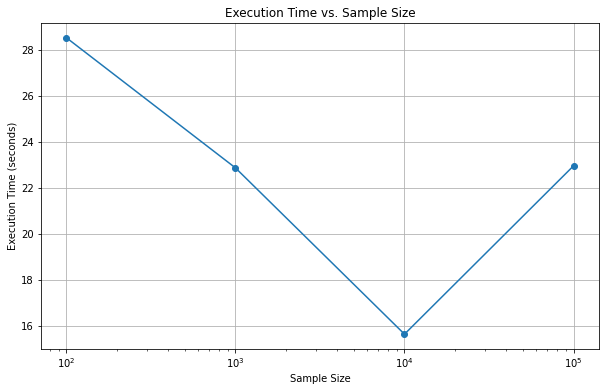

In [98]:
# Run the query execution time processing and calculations here
# List of the sample sizes
sample_sizes = [10 ** i for i in range(2, 6)]

# Dictionary to hold the execution times
execution_times = {}

for sample_size in sample_sizes:
    print(f"Running the query for sample size: {sample_size}")
    business_sample_path = f"../../data/business_sample_{sample_size}.csv"
    business_sample_df = spark.read.csv(business_sample_path, header=True, inferSchema=True)
    review_sampled_path = f"../../data/reviews_sample_{sample_size}.csv"
    review_sample_df = spark.read.csv(review_sampled_path, header=True, inferSchema=True)

    times = []
    for i in range(10):
        start_time = time.time()
        query_5(business_sample_df, review_sampled_df)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time:.2f} seconds")
        times.append(execution_time)
    
    # Take the average execution time
    average_execution_time = np.average(times)
    
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")

    # Save the sample size and corresponding execution time into a dictionary
    execution_times[sample_size] = execution_time

# Print the execution times
print(execution_times)

# Plot the graph with execution times
plot_graph_with_times(execution_times)

# Task 6

Make a task that tests the index. Compare the before and after performance of that.

In [ ]:
# Filter businesses by city
sf_business_df = business_df.filter(business_df.city == "San Francisco")

# Join with reviews and users
joined_df = (sf_business_df
    .join(review_sampled_df, sf_business_df.business_id == review_sampled_df.business_id)
    .join(users_df, review_sampled_df.user_id == users_df.user_id))
# Filter businesses by city
sf_business_df = business_df.filter(business_df.city == "San Francisco")

# Join with reviews and users
joined_df = (sf_business_df
    .join(review_sampled_df, sf_business_df.business_id == review_sampled_df.business_id)
    .join(users_df, review_sampled_df.user_id == users_df.user_id)
    # Select necessary columns explicitly to avoid ambiguity
    .select(
        users_df.user_id,
        users_df.name,
        review_sampled_df.stars
    ))

# Group by user and calculate average stars
result = (joined_df
    .groupBy("user_id", "name")
    .avg("stars")
    .orderBy("avg(stars)", ascending=False)
    .limit(10))

# Display the result
result.show()
# Group by user and calculate average stars
result = (joined_df
    .groupBy("user_id", "name")
    .avg("stars")
    .orderBy("avg(stars)", ascending=False)
    .limit(10))

# Display the result
result.show()

AnalysisException: "stars" is not a numeric column. Aggregation function can only be applied on a numeric column.

# PySpark Analysis

In [ ]:
review_sampled_df = spark.read.csv(review_file_path, header=True, inferSchema=True)